# Демонстрация автоматического отбора признаков с помощью PrimarySelection

## Структура ноутбука:
- Применение библиотеки PrimarySelection для задач мультиклассификации
    * Приведение числовых признаков к типу float, замена бесконечных значений;
    * Проверка на пропущенные значения;
    * Корреляционный анализ;
    * Анализ признаков относительно глубины алгоритма;
    * Проверка всех библиотек Permutation Importance (sklearn, eli5, собственный kib)   

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, NansAnalysis, PrimarySelection, base_pipe

In [4]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('catboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.3.5
numpy:  1.21.5
scipy:  1.7.3
sklearn:  1.0.2
catboost:  1.1.1
matplotlib:  3.5.1
autobinary:  1.0.7


* eli5==0.13.0

# Для мультиклассовой задачи

In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1500, n_features=25, n_informative=8, n_redundant=17, n_classes=3, random_state=42)
sample = pd.DataFrame(X)
sample.columns = [f'feature_{i}' for i in range(len(sample.columns))]


sample['target'] = y

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1500, 26)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,target
0,0.534065,2.522191,0.142878,2.921343,-0.837638,-3.631808,-1.386599,-0.624858,1.923359,-3.754648,...,4.320680,-2.841549,-0.615687,-2.638303,-0.941292,2.561901,1.411905,2.305033,-1.411519,0
1,1.912064,3.015669,-4.114627,-1.720778,-1.049952,-3.575342,-0.719276,4.859142,-1.959112,5.192894,...,1.411251,-2.774986,1.396434,0.908956,5.203906,0.584113,4.710460,-3.295091,-1.562306,1


In [6]:
num_columns = sample.drop(columns='target').columns.tolist()

cat_columns = [
]

features = num_columns+cat_columns

target = 'target'

In [7]:
# Обновление пайплайна трансформации

prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns
)

Определены только количественные переменные!


In [8]:
# обработка бесконечных и пропущенных значений

nans = NansAnalysis(df=sample)

sample = nans.to_types(num_columns=num_columns)
sample.head()

Все бесконечные значения заменены на пропуски, количественные переменные приведены к типу float!


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,target
0,0.534065,2.522191,0.142878,2.921343,-0.837638,-3.631808,-1.386599,-0.624858,1.923359,-3.754648,...,4.320680,-2.841549,-0.615687,-2.638303,-0.941292,2.561901,1.411905,2.305033,-1.411519,0
1,1.912064,3.015669,-4.114627,-1.720778,-1.049952,-3.575342,-0.719276,4.859142,-1.959112,5.192894,...,1.411251,-2.774986,1.396434,0.908956,5.203906,0.584113,4.710460,-3.295091,-1.562306,1
2,-2.478758,-0.117791,-1.892064,-0.522197,2.022059,-2.492530,4.685603,0.717937,-3.747447,5.508374,...,-2.210135,1.626188,-2.476625,2.967870,-1.083371,-2.959888,-1.049414,1.009348,-1.005730,1
3,5.449429,2.462388,-1.389078,-1.358669,-1.137811,-3.977899,-0.286726,5.592796,-0.790865,1.952978,...,3.908572,-5.067503,2.273161,-2.069727,4.616372,2.628732,1.779868,-3.778193,-2.450488,1
4,2.996450,1.679707,0.957340,0.335399,0.517542,0.232261,0.050459,1.575589,-1.256255,-1.562188,...,5.169438,-4.558637,0.725680,-2.687195,1.050832,3.433512,0.376206,-1.941337,-0.225461,0


In [9]:
# Проводим анализ на пропущенные значения. Столбцы имеющие пропусков больше percent.

feat_after_nans = nans.fit(percent = 0.9)

# Обновляем факторы

num_columns = list(filter(lambda x: x in feat_after_nans, num_columns))
cat_columns = list(filter(lambda x: x in feat_after_nans, cat_columns))

Количество столбцов до: 26
Удалены столбцы, имеющие долю пропусков > 90.0 %, количество оставшихся : 26 


In [10]:
# Функция nans_df - датафрейм с пропущенными значениями

nans.nans_df

,feature,cnt_null,share_nans
0,feature_0,0,0.0
1,feature_1,0,0.0
24,feature_24,0,0.0
23,feature_23,0,0.0
22,feature_22,0,0.0
21,feature_21,0,0.0
20,feature_20,0,0.0
19,feature_19,0,0.0
18,feature_18,0,0.0
17,feature_17,0,0.0


In [11]:
# Разделение на обучение и тест

X_train, X_val, y_train, y_val = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

# Использование класса PrimarySelection

### Класс PrimarySelection используется для анализа качества данных и отбора факторов.

* В параметры передаются тренировочная выборка, пайплайн обработки факторов, количественные и категориальные списки факторов, название таргета, тип модели и тип задачи.

In [12]:
# Инициализация класса первичного отбора факторов

feature_selection = PrimarySelection(df_train=X_train,
                                     base_pipe=base_pipe,
                                     num_columns=num_columns,
                                     cat_columns=cat_columns,
                                     target=target,
                                     model_type='catboost',
                                     task_type='multiclassification')

Класс первичного отбора факторов инициализирован!


## 1. Корреляционный анализ

* method - метод расчета корреляций (spearman / pearson);
* threshold - порог при котором фактор является коррелирующим;
* drop_with_most_correlations:
    * True - исключается фактор с наибольшим количеством коррелирующих с ним факторов с корреляцией выше порогового значения;
    * False - исключается фактор с наименьшим Джини из списка коррелирующих факторов.

In [13]:
# Корреляционный анализ 

feat_after_corr = feature_selection.corr_analysis(method='spearman',
                                                  threshold=0.5, 
                                                  drop_with_most_correlations=True)

Определены только количественные переменные!
Количество факторов до: 25
Количество факторов после корреляционного анализа: 12


In [14]:
# функция corr_df - датафрейм с коррелирующими факторами

feature_selection.corr_df

,Корреляция более 50.0%
feature_16,"['feature_17', 'feature_19', 'feature_21', 'fe..."
feature_0,"['feature_15', 'feature_17', 'feature_19', 'fe..."
feature_9,"['feature_19', 'feature_8', 'feature_15', 'fea..."
feature_12,"['feature_14', 'feature_6', 'feature_24', 'fea..."
feature_20,"['feature_21', 'feature_22', 'feature_4', 'fea..."
feature_24,"['feature_17', 'feature_14', 'feature_6']"
feature_19,"['feature_15', 'feature_10', 'feature_18']"
feature_3,"['feature_8', 'feature_11', 'feature_7']"
feature_6,"['feature_4', 'feature_14']"
feature_21,"['feature_2', 'feature_13']"


In [15]:
# функция metric_res - датафрейм с метриками однофакторного анализа

feature_selection.metric_res

,metric
feature_9,0.0844
feature_13,0.0719
feature_3,0.0701
feature_16,0.0651
feature_21,0.0597
feature_2,0.0585
feature_19,0.0582
feature_8,0.0543
feature_4,0.0424
feature_7,0.0375


In [16]:
# Функция feat_after_corr - список факторов после корреляционного анализа

feature_selection.feat_after_corr

['feature_14',
 'feature_17',
 'feature_5',
 'feature_11',
 'feature_4',
 'feature_13',
 'feature_2',
 'feature_23',
 'feature_10',
 'feature_8',
 'feature_1',
 'feature_15']

In [17]:
# Прописываем необходимую функцию для метрики

from sklearn.metrics import f1_score

def f1_macro(ytr,ypred):
    return f1_score(ytr,ypred,average='macro')

## 2. Отбор признаков с помощью углубления древовидных алгоритмов

### Метод depth_analysis используется для отбора факторов относительно глубины алгоритма.

* В параметры передаются список факторов и максимальная глубина до которой будут расчитываться важности признаков.


* На выходе мы получаем таблицу из факторов отсортированных по важности, таблицу из факторов отрсортированных по рангу признака, список факторов из отсортированных по важности, список факторов из отсортированных по рангу.


    * Аргоритм отбора относительно глубины: модель обучается на всех факторах в цикле с глубиной от 1 до максимально указанной. Далее выводятся важности по каждому признаку в каждой глубине. После чего значение усредняется по каждому признаку и сортируется по убыванию.
    
    * Алгоритм отбора относительно ранга в глубине: аналогично предыдущему, только при каждом значении глубины отбираются признаки со значением важности >0, по ним расставляются ранговые значения, и расчитывается среднее внутри каждой глубины. После чего ранги усредняются относительно глубин и сортируются по убыванию.

In [18]:
# Анализ относительно глубины

depth_features, rank_features = feature_selection.depth_analysis(features=feat_after_corr,
                                                                 max_depth=3)

Определены только количественные переменные!


  0%|          | 0/3 [00:00<?, ?it/s]

Количество признаков до отбора: 12
Количество признаков после mean importance относительно глубины: 12
Количество признаков после mean rank относительно глубины: 12


In [19]:
# Табличное представление результатов анализа

feature_selection.fi

,importance_depth_1,importance_depth_2,importance_depth_3,mean_importance,mean_rank
feature_13,28.770985,19.463850,16.498159,21.577665,0.153846
feature_2,16.714830,13.902896,12.071244,14.229657,0.141026
feature_8,10.657957,11.693217,11.900432,11.417202,0.119658
feature_15,12.820015,10.107018,10.411278,11.112771,0.119658
feature_17,11.636194,8.247857,6.408906,8.764319,0.089744
feature_11,5.572935,9.138919,9.881758,8.197871,0.094017
feature_14,5.786533,7.467725,7.996531,7.083596,0.085470
feature_23,0.821969,6.103307,7.207279,4.710851,0.059829
feature_5,4.502517,4.516939,4.738437,4.585964,0.047009
feature_1,1.942109,4.911817,5.791662,4.215196,0.051282


# 3. Проверка Permutation Importance на одной модели с разными алгоритмами sklearn, eli5, собственный код (kib)

    * Код является примером. Не обязательно использовать все три способа. Необходимо отталкиваться от размера выборки и типа задачи (классификация, мультикласс, регрессия). Для задач классификации наиболее оптимальными являются eli5 / kib. Для задач регрессии kib / sklearn.
    
    * Для начала применяем конвеер трансформации категориальных и численных признаков, после чего обучаем алгоритм при наших ранее заданных параметрах.

In [20]:
# Задаем стратегию деления больших данных для расчета permutation importance на подмножестве обучающего множества

strat = StratifiedKFold(n_splits=3,
                        shuffle=True,
                        random_state=42)

* На вход подаются список факторов после анализа относительно глубины / корреляционного анализа / анализа пропусков, стратегия деления, группа для стратификации (при необходимости), количество перемешиваний, тип перемешивания, число ядер, метрика и направление метрики (для типа перемешивания kib)

### 3.1 От Sklearn

In [21]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='sklearn',
                                       n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (700, 26) ; Среднее значение таргета: 0.9985714285714286

Размер тестового подмножества для Permutation importance: (350, 26) ; Среднее значение таргета: 0.9942857142857143
Определены только количественные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_13,0.106143,0.095143
feature_8,0.106143,0.092000
feature_15,0.106000,0.087714
feature_14,0.090714,0.070286
feature_11,0.079429,0.050857
feature_2,0.070857,0.050000
feature_23,0.064143,0.043714
feature_1,0.033429,0.034286
feature_5,0.026429,0.022571


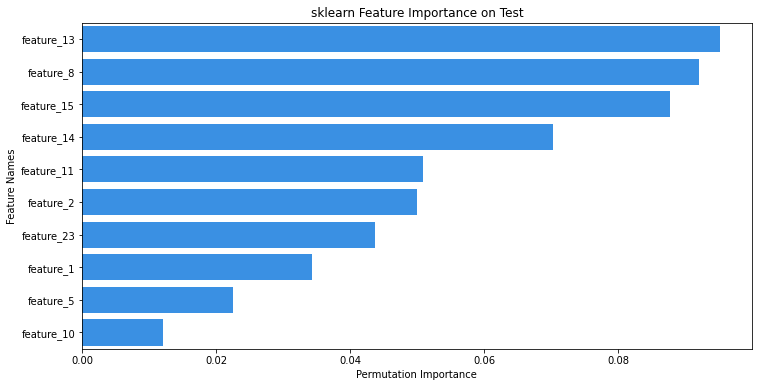

In [22]:
# вызов функции permutation_plot отрисовывает топ важности по методу permutation importance

feature_selection.permutation_plot(top=10, figsize=(12,6))

#### Вызов функции select_features выдает список отобранных признаков. 

* Отбор происходит следующим образом:
    * Если на тестовом множестве значение метрики относительно перемешанного факторо и рандомного признака ниже нуля, то отбираются все признаки выше нуля.
    * Если рандомный признак имеет положительное значение на тестовом множестве, то отбираются все признаки выше значения при рандомном признаке.

In [23]:
feature_selection.select_features()

13 признаков было до Permutation Importance 

12 признаков после Permutation Importance от sklearn


['feature_13',
 'feature_8',
 'feature_15',
 'feature_14',
 'feature_11',
 'feature_2',
 'feature_23',
 'feature_1',
 'feature_5',
 'feature_10',
 'feature_17',
 'feature_4']

### 3.2 От Eli5

In [24]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='eli5',
 #                                      n_jobs=-1,
 #                                      metric=roc_auc_score,
 #                                      higher_is_better=True
                                      )

Размер обучающего подмножества для Permutation importance: (700, 26) ; Среднее значение таргета: 0.9985714285714286

Размер тестового подмножества для Permutation importance: (350, 26) ; Среднее значение таргета: 0.9942857142857143
Определены только количественные переменные!


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_15,0.101429,0.094000
feature_13,0.105857,0.088000
feature_8,0.112429,0.084857
feature_14,0.093000,0.057143
feature_2,0.073714,0.052857
feature_11,0.084571,0.049714
feature_23,0.069429,0.042286
feature_1,0.033143,0.029714
feature_5,0.025714,0.024286


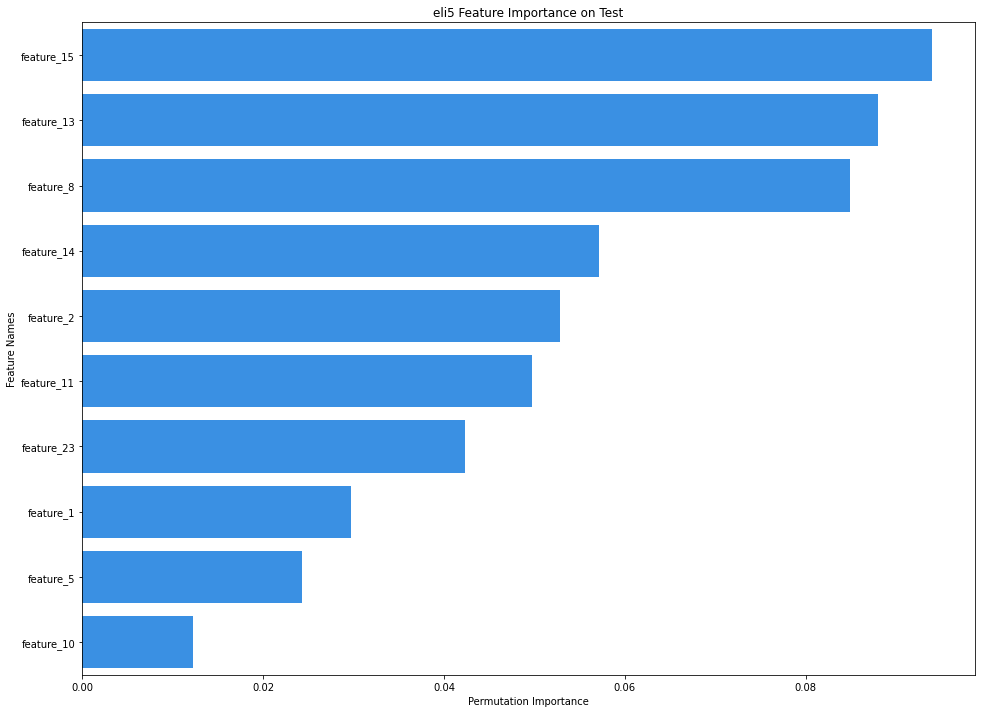

In [25]:
feature_selection.permutation_plot(figsize=(16,12), top=10)

In [26]:
feature_selection.select_features()

13 признаков было до Permutation Importance 

12 признаков после Permutation Importance от eli5


['feature_15',
 'feature_13',
 'feature_8',
 'feature_14',
 'feature_2',
 'feature_11',
 'feature_23',
 'feature_1',
 'feature_5',
 'feature_10',
 'feature_17',
 'feature_4']

### 3.3 Самописный permutation kib

In [27]:
feature_selection.permutation_analysis(features=depth_features,
                                       strat=strat,
                                       n_iter=10,
                                       permute_type='kib',
                                       n_jobs=-1,
                                       metric=f1_macro,
                                       higher_is_better=True)

Размер обучающего подмножества для Permutation importance: (700, 26) ; Среднее значение таргета: 0.9985714285714286

Размер тестового подмножества для Permutation importance: (350, 26) ; Среднее значение таргета: 0.9942857142857143
Определены только количественные переменные!
Расчет Permutation Importance на Train


100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Расчет Permutation Importance на Test


100%|██████████| 13/13 [00:00<00:00, 123.57it/s]


,Perm_Importance_Tr,Perm_Importance_Te
Feature,,
feature_8,0.102410,0.097363
feature_13,0.104988,0.094573
feature_15,0.110386,0.090820
feature_14,0.093194,0.065229
feature_11,0.081510,0.048686
feature_2,0.065295,0.047581
feature_23,0.058594,0.043722
feature_1,0.029939,0.029391
feature_5,0.026979,0.018304


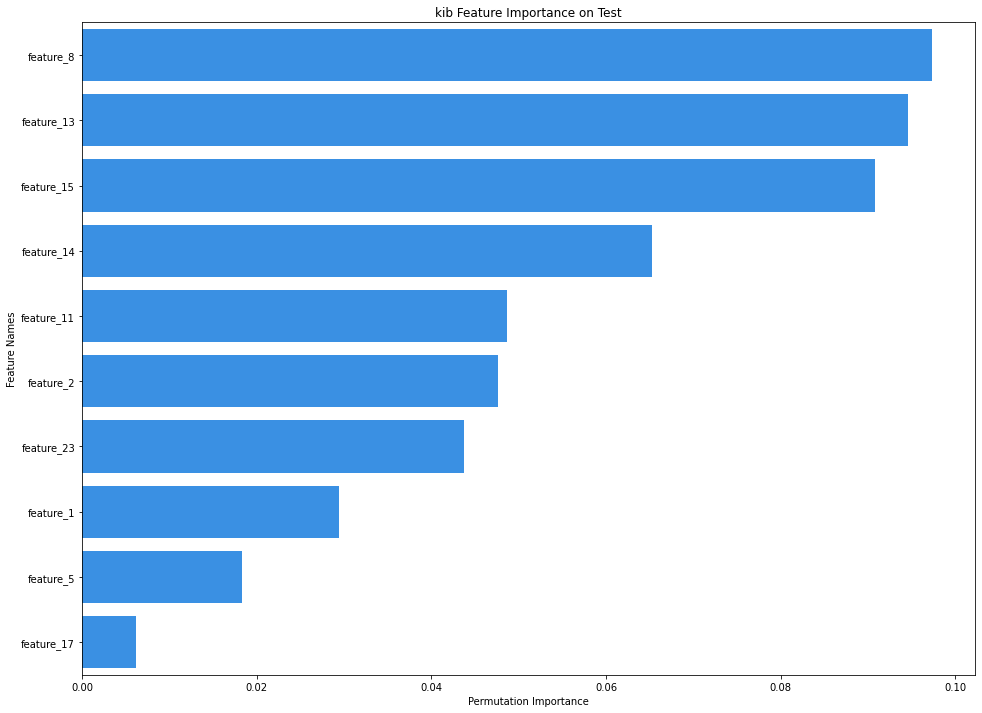

In [28]:
feature_selection.permutation_plot(figsize=(16,12), top=10)

In [29]:
feature_selection.select_features()

13 признаков было до Permutation Importance 

11 признаков после Permutation Importance от kib


['feature_8',
 'feature_13',
 'feature_15',
 'feature_14',
 'feature_11',
 'feature_2',
 'feature_23',
 'feature_1',
 'feature_5',
 'feature_17',
 'feature_10']